In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

טוען את התמונות מהדרייב

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


מעביר את התמונות לסט נתונים, אחד לאימון ואחד לבדיקת ביצועים.
בסט נתונים יש 3 קטגוריות: אריה, דולפין וסוס.
גודל התמונות 256 על 256
ומשתמש ב crop_to_aspect_ratio=True על מנת שחתוך את התמונות לגודל 256 על 256

In [ ]:
#training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/projecton3_images/train',
    labels="inferred",
    label_mode="categorical",
    image_size=(256, 256),
    shuffle=True,
    crop_to_aspect_ratio=True,
)
#validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/projecton3_images/val',
    labels="inferred",
    label_mode="categorical",
    image_size=(256, 256),
    shuffle=True,
    crop_to_aspect_ratio=True,
)

Found 25 files belonging to 3 classes.
Found 8 files belonging to 3 classes.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None, 3)), types: (tf.float32, tf.float32)>

הצגה של כמה תמונות מהסט נתונים

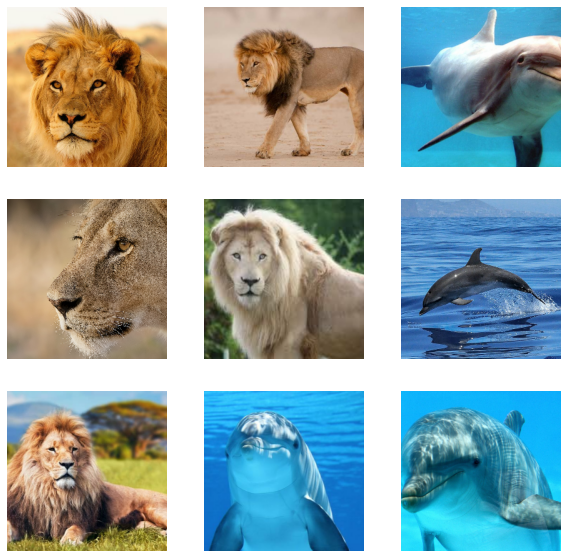

In [ ]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

יצירת פעולת האומנטציה,
הפיכה אופקית של התמונה, סיבוב אקראי, הזזת התמונה לצדדים ושינוי ניגודיות אקראי

In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip('horizontal'),
     layers.RandomRotation(0.1),
     layers.RandomTranslation(
     height_factor=(-0.2, 0.3),
     width_factor=(-0.2, 0.3),
     fill_mode="nearest",
     interpolation="nearest"),
     layers.RandomContrast(0.1,0.1),
    ]
)

הצגה של פעולת האוגמנטציה על התמונות.
(נשתמש בפעולה זאת בתוך המודל על מנת ליצור מגוון רחב יותר של תמונות ושהמודל יוכל ללמוד יותר טוב מדוגמאות שונות)

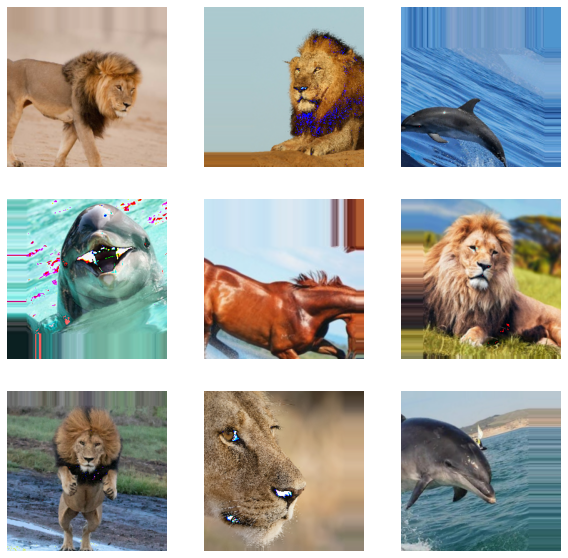

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(images[i])
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.axis("off")

פעולות המאפשרות אימון על GPU

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 456499831186947673
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8626966662479157059
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
from keras import backend as K
K._get_available_gpus() 

['/device:GPU:0']

ייבוא של מודל מאומן בשם "Xception" על סט הנתונים imagenet על גודל תמונה 256 על 256 RGB ובלי השכבה האחרונה שבעצם קובעת לאיזה קטגורייה התמונה שייכת ובכך מאפשר שימוש של מודל מאומן שמצליח לזהות טוב דברים בתמונה ורק נשאר לאמן את השכבה האחרונה שנוסיף אחר כך בכדי לעשות סיווג לשלוש הקבוצות(אריה, דולפין וסוס)

In [ ]:
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)

מגדיר את החלק המאומן של המודל שלא ישנה את הפרמטרים המאומנים ובעצם לא "ילמד אותם"

In [ ]:
base_model.trainable = False

בניית המודל

In [ ]:
inputs = keras.Input(shape=(256,256,3))

# שימוש בפעולת האוגמנטציה ממקודם
l1 = data_augmentation(inputs)


#שימוש במודל המאומן
X1 = base_model(l1)

#שימוש ב average pooling
X2 = layers.GlobalAveragePooling2D()(X1)

#הוספת שכבה אחרונה אשר תלמד לזהות ולסווג לשלוש הקבוצות בעזרת המודל המאומן
outputs = layers.Dense(3, activation='softmax')(X2)
model = keras.Model(inputs, outputs)

print(model.summary())

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_27 (Sequential)  (256, 256, 3)             0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_13  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
__________________________________________

תיאור של המודל

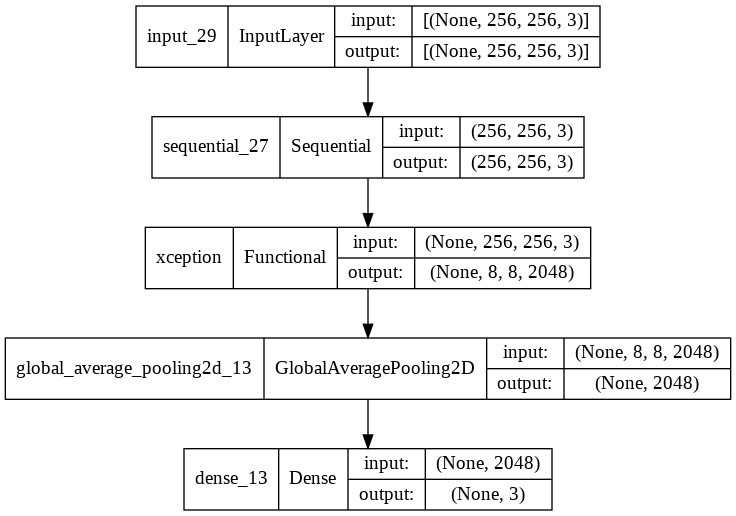

In [ ]:
plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

אימון על סט הנתונים ובדיקת ביצועים על סט ה validation

In [ ]:
batch_size = 128
epochs = 15

history = model.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=val_ds)

Epoch 1/15
1/1 [==============================] - 6s 6s/step - loss: 9.1435 - accuracy: 0.2800 - val_loss: 3.5403 - val_accuracy: 0.6250
Epoch 2/15
1/1 [==============================] - 1s 1s/step - loss: 11.7557 - accuracy: 0.3200 - val_loss: 2.9546 - val_accuracy: 0.7500
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 9.8291 - accuracy: 0.4000 - val_loss: 1.8938 - val_accuracy: 0.7500
Epoch 4/15
1/1 [==============================] - 1s 1s/step - loss: 4.5574 - accuracy: 0.3600 - val_loss: 1.2032 - val_accuracy: 0.7500
Epoch 5/15
1/1 [==============================] - 1s 1s/step - loss: 4.4754 - accuracy: 0.4800 - val_loss: 2.3854 - val_accuracy: 0.3750
Epoch 6/15
1/1 [==============================] - 1s 1s/step - loss: 3.8456 - accuracy: 0.5600 - val_loss: 2.0772 - val_accuracy: 0.6250
Epoch 7/15
1/1 [==============================] - 1s 1s/step - loss: 4.2340 - accuracy: 0.6400 - val_loss: 0.6013 - val_accuracy: 0.7500
Epoch 8/15
1/1 [========================

In [ ]:
model.evaluate(val_ds)

1/1 [==============================] - 0s 239ms/step - loss: 0.6345 - accuracy: 0.8750


[0.6345386505126953, 0.875]

אפשר לראות שהמודל הגיע לביצועים יחסית טובים לסט נתונים מאוד מאוד קטן

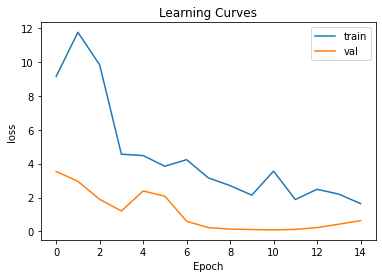

In [ ]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

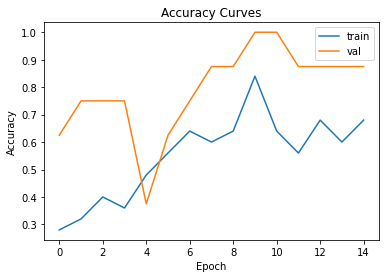

In [ ]:
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

יצירה של עוד מודל על מנת לעשות fine tuning ולנסות להגיע לביצועים טובים יותר

In [ ]:
base_model2 = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)

In [ ]:
base_model2.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_30[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

עוברים על כל השכבות בלולאת for ומגדירים כל שכבה כאי ניתנת לאימון עד שמגיעים לבלוק ה14 של המודל ובעצם משם מאפשרים לא ללמד את השכבות על סט הנתונים

In [ ]:
for layer in base_model2.layers:
  if (layer.name=='block14_sepconv1'):
    break
  layer.trainable = False

הגדרת המודל

In [ ]:
inputs = keras.Input(shape=(256,256,3))
l1 = data_augmentation(inputs)
X1 = base_model2(l1)
X2 = layers.GlobalAveragePooling2D()(X1)
X3 = layers.Dropout(0.2)(X2)
outputs = layers.Dense(3, activation='softmax')(X3)
model2 = keras.Model(inputs, outputs)

print(model2.summary())

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_27 (Sequential)  (256, 256, 3)             0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_14  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 3)                 6147      
                                                          

תיאור המודל, אפשר לראות למעלה שמספר הפרמטרים שניתנים לאימון גדול יותר מהמודל הקודם.

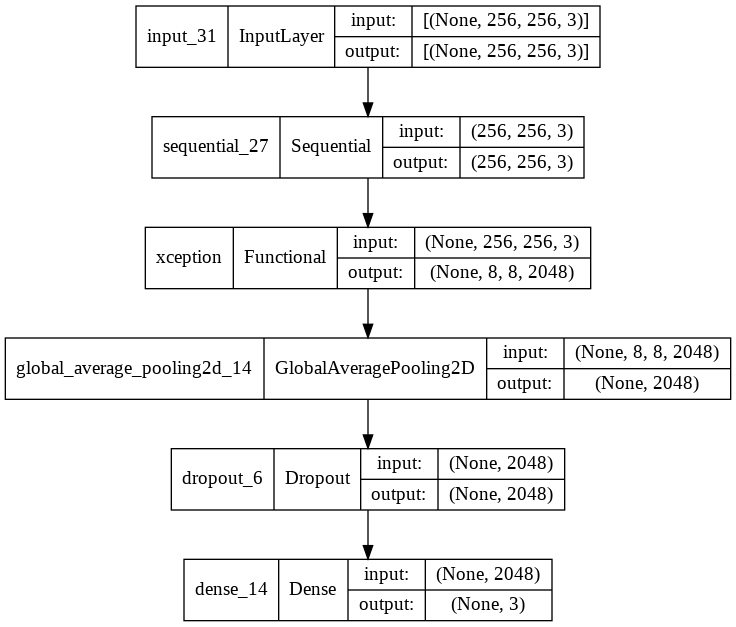

In [ ]:
plot_model(model2, 'model.png', show_shapes=True)

In [ ]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

אימון המודל

In [ ]:
history2 = model2.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=val_ds)

Epoch 1/15
1/1 [==============================] - 6s 6s/step - loss: 1.0892 - accuracy: 0.4000 - val_loss: 1.4952 - val_accuracy: 0.6250
Epoch 2/15
1/1 [==============================] - 1s 1s/step - loss: 0.9981 - accuracy: 0.5200 - val_loss: 0.2970 - val_accuracy: 0.8750
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 0.8333 - accuracy: 0.6400 - val_loss: 1.4680 - val_accuracy: 0.7500
Epoch 4/15
1/1 [==============================] - 1s 1s/step - loss: 0.6616 - accuracy: 0.8000 - val_loss: 5.6143 - val_accuracy: 0.5000
Epoch 5/15
1/1 [==============================] - 1s 1s/step - loss: 0.6420 - accuracy: 0.6400 - val_loss: 2.4077 - val_accuracy: 0.7500
Epoch 6/15
1/1 [==============================] - 1s 1s/step - loss: 0.5267 - accuracy: 0.8000 - val_loss: 1.0986 - val_accuracy: 0.7500
Epoch 7/15
1/1 [==============================] - 1s 1s/step - loss: 0.4859 - accuracy: 0.8400 - val_loss: 0.6494 - val_accuracy: 0.7500
Epoch 8/15
1/1 [=========================

אפשר לראות שהמודל מגיע ל overfit משמע התאים את עצמו רק לנתונים של האימון ומגיע לביצועים רעים מאוד ב validation set

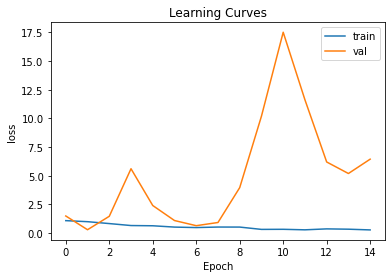

In [ ]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()
plt.show()

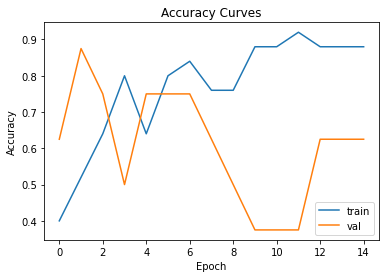

In [ ]:
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='val')
plt.legend()
plt.show()

מסקנות: אין מספיק נתונים בשביל ליצור מודל מספיק אמין, אבל אפשר לראות שהשימוש במודל מאומן מאוד עוזר להגיע לביצועים טובים גם על סט נתונים קטן ובזמן אימון קצר מאוד.